## Transfer Learning VGG 16 and VGG 19 using Keras

Please download the dataset from the below url

In [2]:
# import the libraries as shown below

from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50
#from keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

In [3]:
# re-size all the images to this
IMAGE_SIZE = [224, 224]

train_path = 'Datasets/train'
valid_path = 'Datasets/test'


In [5]:
# Import the resnet50 library as shown below and add preprocessing layer to the front of Resnet50
# Here we will be using imagenet weights

resnet = ResNet50(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)




In [7]:
resnet.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)    │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_pad (ZeroPadding2D)     │ (None, 230, 230, 3)       │               0 │ input_layer_1[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_conv (Conv2D)           │ (None, 112, 112, 64)      │           9,472 │ conv1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_bn (BatchNormalization) │ (None, 112, 112, 64)      │             256 │ conv1_conv[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_relu (Activation)       │ (None, 112, 112, 64)      │               0 │ conv1_bn[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pad (ZeroPadding2D)     │ (None, 114, 114, 64)      │               0 │ conv1_relu[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pool (MaxPooling2D)     │ (None, 56, 56, 64)        │               0 │ pool1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_conv (Conv2D)  │ (None, 56, 56, 64)        │           4,160 │ pool1_pool[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_bn             │ (None, 56, 56, 64)        │             256 │ conv2_block1_1_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_relu           │ (None, 56, 56, 64)        │               0 │ conv2_block1_1_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_conv (Conv2D)  │ (None, 56, 56, 64)        │          36,928 │ conv2_block1_1_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_bn             │ (None, 56, 56, 64)        │             256 │ conv2_block1_2_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_relu           │ (None, 56, 56, 64)        │               0 │ conv2_block1_2_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_0_conv (Conv2D)  │ (None, 56, 56, 256)       │          16,640 │ pool1_pool[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_3_conv (Conv2D)  │ (None, 56, 56, 256)       │          16,640 │ conv2_block1_2_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [8]:
# don't train existing weights
for layer in resnet.layers:
    layer.trainable = False

In [9]:
# useful for getting number of output classes
folders = glob('Datasets/train/*')

In [10]:
folders

['Datasets/train\\audi',
 'Datasets/train\\lamborghini',
 'Datasets/train\\mercedes']

In [11]:
x = Flatten()(resnet.output)

In [12]:
prediction = Dense(len(folders), activation='softmax')(x)

# create a model object
model = Model(inputs=resnet.input, outputs=prediction)

In [13]:

# view the structure of the model
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)    │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_pad (ZeroPadding2D)     │ (None, 230, 230, 3)       │               0 │ input_layer_1[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_conv (Conv2D)           │ (None, 112, 112, 64)      │           9,472 │ conv1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_bn (BatchNormalization) │ (None, 112, 112, 64)      │             256 │ conv1_conv[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_relu (Activation)       │ (None, 112, 112, 64)      │               0 │ conv1_bn[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pad (ZeroPadding2D)     │ (None, 114, 114, 64)      │               0 │ conv1_relu[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pool (MaxPooling2D)     │ (None, 56, 56, 64)        │               0 │ pool1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_conv (Conv2D)  │ (None, 56, 56, 64)        │           4,160 │ pool1_pool[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_bn             │ (None, 56, 56, 64)        │             256 │ conv2_block1_1_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_relu           │ (None, 56, 56, 64)        │               0 │ conv2_block1_1_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_conv (Conv2D)  │ (None, 56, 56, 64)        │          36,928 │ conv2_block1_1_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_bn             │ (None, 56, 56, 64)        │             256 │ conv2_block1_2_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_relu           │ (None, 56, 56, 64)        │               0 │ conv2_block1_2_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_0_conv (Conv2D)  │ (None, 56, 56, 256)       │          16,640 │ pool1_pool[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_3_conv (Conv2D)  │ (None, 56, 56, 256)       │          16,640 │ conv2_block1_2_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 23,888,771 (91.13 MB)

 Trainable params: 301,059 (1.15 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [14]:
# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)


In [15]:
# Use the Image Data Generator to import the images from the dataset
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [16]:
# Make sure you provide the same target size as initialied for the image size
training_set = train_datagen.flow_from_directory('Datasets/train',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 64 images belonging to 3 classes.


In [17]:
test_set = test_datagen.flow_from_directory('Datasets/test',
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 58 images belonging to 3 classes.


In [20]:
# fit the model
# Run the cell. It will take some time to execute
r = model.fit(
  training_set,
  validation_data=test_set,
  epochs=50,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3750 - loss: 2.6981  

C:\Users\shivs\anaconda3\envs\carbrand\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2/2 ━━━━━━━━━━━━━━━━━━━━ 19s 8s/step - accuracy: 0.3750 - loss: 3.1110 - val_accuracy: 0.5172 - val_loss: 10.0439
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 4s/step - accuracy: 0.3021 - loss: 14.8861 - val_accuracy: 0.5000 - val_loss: 2.6327
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 4s/step - accuracy: 0.3854 - loss: 4.8556 - val_accuracy: 0.2931 - val_loss: 7.9250
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 4s/step - accuracy: 0.4062 - loss: 5.8215 - val_accuracy: 0.1724 - val_loss: 11.6425
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 4s/step - accuracy: 0.4688 - loss: 6.4136 - val_accuracy: 0.3276 - val_loss: 9.7046
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 4s/step - accuracy: 0.3854 - loss: 6.1546 - val_accuracy: 0.3276 - val_loss: 2.9486
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 4s/step - accuracy: 0.5729 - loss: 1.4704 - val_accuracy: 0.5172 - val_loss: 3.3473
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 4s/step - accuracy: 0.3854 - loss: 3.6608 - val_accuracy: 0.5172 - val_loss: 2.7946
Epoch 9/50
2/2 ━━━━━━━━

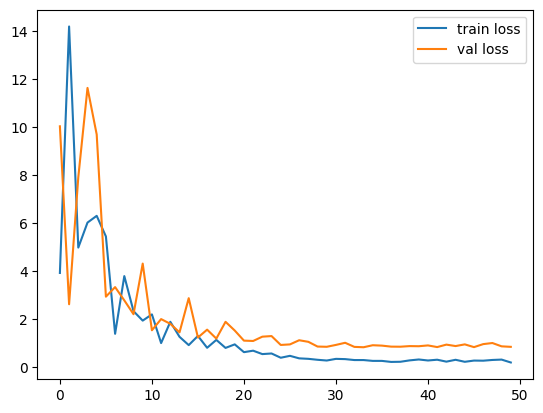

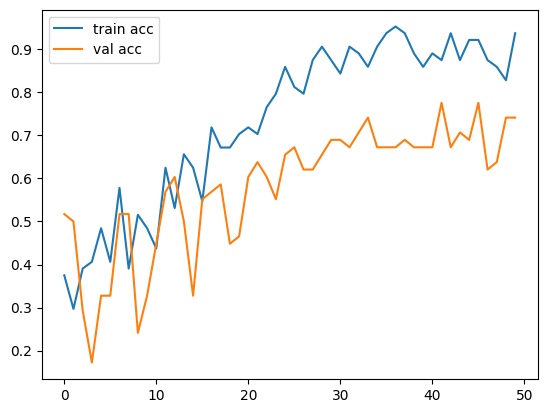

<Figure size 640x480 with 0 Axes>

In [21]:
# plot the loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [22]:
# save it as a h5 file


from tensorflow.keras.models import load_model

model.save('model_resnet50.h5')

In [24]:

y_pred = model.predict(test_set)


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step


In [26]:
y_pred

array([[2.73187868e-02, 6.35943949e-01, 3.36737245e-01],
       [5.32117963e-01, 4.06336963e-01, 6.15450703e-02],
       [2.18244940e-01, 1.21792853e-01, 6.59962177e-01],
       [7.13846564e-01, 6.96882829e-02, 2.16465190e-01],
       [8.45080912e-02, 1.32538576e-03, 9.14166570e-01],
       [1.12954237e-01, 8.64453554e-01, 2.25921888e-02],
       [5.32363169e-02, 7.21089959e-01, 2.25673750e-01],
       [2.26125740e-05, 8.14217638e-05, 9.99895930e-01],
       [4.68579568e-02, 9.51322854e-01, 1.81910372e-03],
       [2.18738019e-02, 1.25456427e-03, 9.76871669e-01],
       [4.89251651e-02, 8.53239179e-01, 9.78356451e-02],
       [3.28370333e-02, 2.36797822e-03, 9.64794993e-01],
       [8.04440752e-02, 2.88622886e-01, 6.30933046e-01],
       [3.90192628e-01, 2.33580455e-01, 3.76226962e-01],
       [1.83415916e-02, 9.48268533e-01, 3.33898999e-02],
       [2.41261408e-01, 4.27105606e-01, 3.31632912e-01],
       [8.70700061e-01, 3.90547724e-03, 1.25394493e-01],
       [6.43375870e-06, 4.48106

In [25]:
import numpy as np
y_pred = np.argmax(y_pred, axis=1)

In [26]:
y_pred

array([1, 1, 1, 1, 2, 2, 0, 1, 2, 1, 2, 0, 2, 2, 2, 2, 2, 0, 2, 1, 1, 2,
       1, 0, 1, 1, 1, 1, 1, 0, 2, 0, 0, 2, 1, 1, 1, 2, 0, 1, 2, 2, 1, 1,
       1, 1, 1, 1, 1, 1, 2, 1, 0, 1, 1, 0, 1, 1])

In [27]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

In [28]:
model=load_model('model_resnet50.h5')

In [40]:
#img_data

In [42]:
img=image.load_img('Datasets/Test/lamborghini/11.jpg',target_size=(224,224))



In [43]:
x=image.img_to_array(img)
x

array([[[252., 252., 252.],
        [252., 252., 252.],
        [252., 252., 252.],
        ...,
        [194., 188., 174.],
        [215., 209., 197.],
        [241., 235., 223.]],

       [[252., 252., 252.],
        [252., 252., 252.],
        [252., 252., 252.],
        ...,
        [247., 245., 233.],
        [245., 242., 233.],
        [244., 241., 232.]],

       [[252., 252., 252.],
        [252., 252., 252.],
        [252., 252., 252.],
        ...,
        [245., 248., 241.],
        [244., 250., 248.],
        [244., 250., 248.]],

       ...,

       [[190., 206., 229.],
        [190., 206., 229.],
        [190., 206., 229.],
        ...,
        [172., 179., 187.],
        [171., 180., 187.],
        [171., 180., 187.]],

       [[187., 205., 227.],
        [187., 205., 227.],
        [187., 205., 227.],
        ...,
        [172., 179., 187.],
        [171., 180., 187.],
        [171., 180., 187.]],

       [[185., 206., 227.],
        [185., 206., 227.],
        [187., 2

In [44]:
x.shape

(224, 224, 3)

In [45]:
x=x/255

In [46]:
x=np.expand_dims(x,axis=0)
img_data=preprocess_input(x)
img_data.shape

(1, 224, 224, 3)

In [47]:
model.predict(img_data)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


array([[1.3904666e-03, 4.3369550e-04, 9.9817586e-01]], dtype=float32)

In [48]:
a=np.argmax(model.predict(img_data), axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


In [49]:
a==1

array([False])

In [38]:
import pickle

In [39]:
file = open('model_resnet50_.pkl','wb')

# dump information to that file
pickle.dump(model, file)